In [1]:
# notebook ran in pandas21 environment
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from Bio.Blast import NCBIWWW
from Bio import SeqIO
from Bio import SearchIO
import seaborn as sns
from matplotlib import gridspec
from itertools import combinations
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import time
import os.path
from os import path

# function to create colour dictionaries from a colour map and a list of items
def colourDict(data,cmap=mpl.cm.viridis,sort=False):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name. If sort = False, the function takes an ordered list of unique elements
    """
    cmap=cmap # default viridis
    data_unique=data if sort == False else list(set(data)) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

In [3]:
%%bash
# uploading the header from the BAM files, before calling SNPs, to make sure to include the sites that were filtered out
# for not being variants

head P13454_101_selected.file
tail P13454_101_selected.file
# one indexed

NODE_142896_length_1000_cov_88.811640 1000
NODE_142898_length_1000_cov_63.057143 1000
NODE_142899_length_1000_cov_56.255026 1000
NODE_142900_length_1000_cov_35.582011 1000
NODE_142902_length_1000_cov_34.162963 1000
NODE_142903_length_1000_cov_33.341799 1000
NODE_142904_length_1000_cov_32.813757 1000
NODE_142905_length_1000_cov_31.859259 1000
NODE_142906_length_1000_cov_31.044444 1000
NODE_142907_length_1000_cov_30.198942 1000
NC_026001.1_RagTag_RagTag 14419170
NC_026002.1_RagTag_RagTag 16236507
NC_025998.1_RagTag_RagTag 16309369
NC_026000.1_RagTag_RagTag 18012598
NC_025999.1_RagTag_RagTag 18622621
NC_025997.1_RagTag_RagTag 23524965
NC_025996.1_RagTag_RagTag 23738005
NC_025995.1_RagTag_RagTag 25755588
NC_025994.1_RagTag_RagTag 30374397
NC_025993.1_RagTag_RagTag 31286264


In [18]:
bamheader = pd.read_csv('./P13454_101_selected.file', sep ='\s', names = ['contig','length'], engine='python')
bamheader.sort_values(by = 'contig', inplace = True)
bamheader.reset_index(inplace = True)
bamheader

,index,contig,length
0,94935,NC_017602.1_RagTag_RagTag,49414
1,95271,NC_025993.1_RagTag_RagTag,31286264
2,95270,NC_025994.1_RagTag_RagTag,30374397
3,95269,NC_025995.1_RagTag_RagTag,25755588
4,95268,NC_025996.1_RagTag_RagTag,23738005
...,...,...,...
95267,33034,NW_011590365.1_RagTag_RagTag,1519
95268,89244,NW_011590636.1_RagTag_RagTag,6012
95269,47375,NW_011590757.1_RagTag_RagTag,1909
95270,93354,NW_011590802.1_RagTag_RagTag,9893


In [10]:
%%bash

# loading the allele numbers counted from the quality-filtered VCF
# zero means tehre is no commas byt there is a REF and ALT allele
# one comma means there is one REF and two ALT alleles
# since we used the annotations in the VCF to count comas as proxy for alleles
# we need to add "one" to all values
# positions missing in the VCF allele count file are assumed to be non-variable or 
# have allele calls of bad quality and thus, assumed non-variable (it is easier that way)

head allpools_gmref_C1F001_wdup_DP10_fixup_woNAlternate_ADannot.allelenum

#CHROM	POS	REF	ALT	0
NC_017602.1_RagTag_RagTag	49307	TTA	TTG	0
NC_017602.1_RagTag_RagTag	49310	TTGT	TTGG	0
NC_017602.1_RagTag_RagTag	49318	C	T	0
NC_017602.1_RagTag_RagTag	49326	TCGTGAATATC	TCGTGAAGATC	0
NC_017602.1_RagTag_RagTag	49337	CTCG	CTCT	0
NC_017602.1_RagTag_RagTag	49342	T	A	0
NC_017602.1_RagTag_RagTag	49346	G	A	0
NC_017602.1_RagTag_RagTag	49348	G	A	0
NC_017602.1_RagTag_RagTag	49350	C	A	0


In [19]:
allelenum = pd.read_csv('./allpools_gmref_C1F001_wdup_DP10_fixup_woNAlternate_ADannot.allelenum', sep = '\t', 
                       names =['contig','pos','ref','alt','allele_num'], skiprows = 1)
allelenum.sort_values(by = 'contig', inplace = True)
allelenum.reset_index(inplace = True)
allelenum

,index,contig,pos,ref,alt,allele_num
0,0,NC_017602.1_RagTag_RagTag,49307,TTA,TTG,0
1,17,NC_017602.1_RagTag_RagTag,49412,G,A,0
2,16,NC_017602.1_RagTag_RagTag,49406,G,A,0
3,15,NC_017602.1_RagTag_RagTag,49398,G,A,0
4,14,NC_017602.1_RagTag_RagTag,49386,G,A,0
...,...,...,...,...,...,...
1327052,33270,NW_011590757.1_RagTag_RagTag,1769,A,G,0
1327053,33277,NW_011590757.1_RagTag_RagTag,1829,T,C,0
1327054,33287,NW_011590874.1_RagTag_RagTag,3371,G,C,0
1327055,33285,NW_011590874.1_RagTag_RagTag,3339,T,C,0


In [20]:
allelenum['allele_num'] = allelenum['allele_num'] + 1
allelenum

,index,contig,pos,ref,alt,allele_num
0,0,NC_017602.1_RagTag_RagTag,49307,TTA,TTG,1
1,17,NC_017602.1_RagTag_RagTag,49412,G,A,1
2,16,NC_017602.1_RagTag_RagTag,49406,G,A,1
3,15,NC_017602.1_RagTag_RagTag,49398,G,A,1
4,14,NC_017602.1_RagTag_RagTag,49386,G,A,1
...,...,...,...,...,...,...
1327052,33270,NW_011590757.1_RagTag_RagTag,1769,A,G,1
1327053,33277,NW_011590757.1_RagTag_RagTag,1829,T,C,1
1327054,33287,NW_011590874.1_RagTag_RagTag,3371,G,C,1
1327055,33285,NW_011590874.1_RagTag_RagTag,3339,T,C,1


In [24]:
snpsbycontig = allelenum.groupby('contig').count()['alt'].reset_index()
snpsbycontig['length'] = snpsbycontig['contig'].map(dict(zip(bamheader['contig'], bamheader['length'])))
snpsbycontig

,contig,alt,length
0,NC_017602.1_RagTag_RagTag,18,49414
1,NC_025993.1_RagTag_RagTag,6,31286264
2,NC_025994.1_RagTag_RagTag,12,30374397
3,NC_025997.1_RagTag_RagTag,21,23524965
4,NC_025998.1_RagTag_RagTag,2,16309369
...,...,...,...
66607,NW_011590162.1_RagTag_RagTag,4,5659
66608,NW_011590365.1_RagTag_RagTag,4,1519
66609,NW_011590636.1_RagTag_RagTag,24,6012
66610,NW_011590757.1_RagTag_RagTag,15,1909


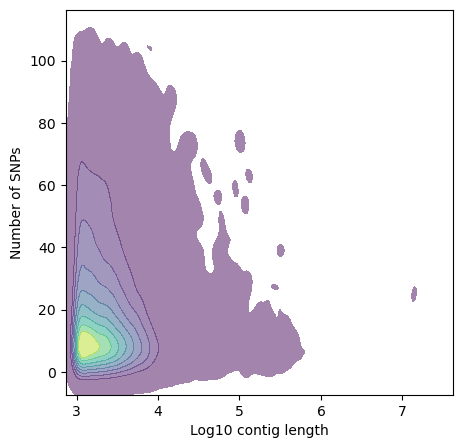

In [34]:
# create dictionary of contig to contig length
cont_len = dict(zip(bamheader['contig'].astype(str), bamheader['length']))

# plot size of contig vc. number of SNPs (SNPs, not alleles)

snpsbycontig = allelenum.groupby('contig').count()['alt'].reset_index()
snpsbycontig['length'] = snpsbycontig['contig'].map(cont_len)
snpsbycontig['length_log10'] = np.log10(snpsbycontig['length'].astype('float'))

fig, ax = plt.subplots(figsize = (5,5), facecolor = 'w')

# ax.scatter(np.log10(snpsbycontig['length']) snpsbycontig['alt'], s = 10)
sns.kdeplot(x = snpsbycontig['length_log10'], y = snpsbycontig['alt'],
            cmap = 'viridis', fill = True, thresh = 0.001, ax = ax, alpha = 0.5)
plt.xlabel('Log10 contig length')
plt.ylabel('Number of SNPs')
plt.show()

In [39]:
cont_len.keys()
# all keys in the dictionary match contigs in the SNP data 
# making sure that I am not missing data because the contig is not in the dict
snpsbycontig['contig'].map(cont_len).isna().describe()

count     66612
unique        1
top       False
freq      66612
Name: contig, dtype: object

In [40]:
# I have the feeling that all SNPs are towards the ends of the contigs. That is not a good sign.
# To check for this, I need to make all SNP possitions comparable accross contigs
# i.e. calculate SNP position as the relative position if the contig was length 100

allelenum['rel_pos'] = ''

for index,row in enumerate(allelenum.itertuples()):
    totallen = cont_len[row.contig]
    relative = (row.pos * 100) / totallen
    allelenum.loc[index,'rel_pos'] = relative

allelenum 

,index,contig,pos,ref,alt,allele_num,rel_pos
0,0,NC_017602.1_RagTag_RagTag,49307,TTA,TTG,1,99.783462
1,17,NC_017602.1_RagTag_RagTag,49412,G,A,1,99.995953
2,16,NC_017602.1_RagTag_RagTag,49406,G,A,1,99.98381
3,15,NC_017602.1_RagTag_RagTag,49398,G,A,1,99.967621
4,14,NC_017602.1_RagTag_RagTag,49386,G,A,1,99.943336
...,...,...,...,...,...,...,...
1327052,33270,NW_011590757.1_RagTag_RagTag,1769,A,G,1,92.666317
1327053,33277,NW_011590757.1_RagTag_RagTag,1829,T,C,1,95.809324
1327054,33287,NW_011590874.1_RagTag_RagTag,3371,G,C,1,98.251239
1327055,33285,NW_011590874.1_RagTag_RagTag,3339,T,C,1,97.318566


In [41]:
allelenum['rel_pos'].describe()

count     1327057.0
unique     362479.0
top           100.0
freq         3868.0
Name: rel_pos, dtype: float64

In [42]:
allelenum['rel_pos'].min()

81.54296875

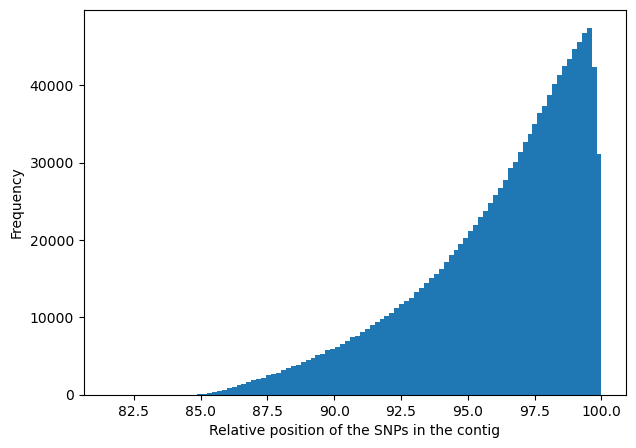

In [44]:
# plotting a histogram

fig,ax = plt.subplots(figsize = (7,5), facecolor = 'w')

ax.hist(allelenum['rel_pos'], bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Relative position of the SNPs in the contig')
plt.show()